# Imports, Dataset loading

In [1]:
import pickle
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from collections import defaultdict
from torch.utils.data import random_split
from torch.utils.data._utils.collate import default_collate
from scipy.signal import convolve2d

import torch
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torch.nn as nn
import torch.nn.functional as F


import ipywidgets as widgets
from ipywidgets import interact_manual
from ipywidgets import Layout, interact, widgets
from IPython.display import clear_output
import time
import beepy

# Loading the datasets from disk
def load_preprocessed_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
    return dataset

loaded_dataset = load_preprocessed_data('preprocessed_data_giant_reduced_melbands_22kres.pkl')

ground_truth_max = 200
ground_truth_min = 80
MAX_OCCURRENCES = 500


# Step 1: Filter data based on ground truth range
filtered_dataset = [item for item in loaded_dataset if ground_truth_min <= item[1] <= ground_truth_max]
#filtered_dataset = filtered_dataset[:int(len(filtered_dataset)/20)]

label_dict = defaultdict(list)
for item in filtered_dataset:
    label = item[1].item()  # .item() ensures we're working with Python int, not a tensor
    label_dict[label].append(item)

# Step 3: Limit each label's items to max MAX_OCCURRENCES
limited_items = []
for label, items in label_dict.items():
    limited_items_for_label = items[:MAX_OCCURRENCES]
    limited_items.extend(limited_items_for_label)

# Step 4: Construct the final dataset (this will be a list, not a ConcatDataset)
filtered_dataset = limited_items
print("dataset length after filtering: ", len(filtered_dataset))

###############################################

train_data_ratio = 0.9
train_len = int(train_data_ratio * len(filtered_dataset))  # 80% for training
val_len = len(filtered_dataset) - train_len  # 20% for validation

train_dataset, val_dataset = random_split(filtered_dataset, [train_len, val_len])

batch_size_new = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size_new, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_new, shuffle=True)
input_shape = train_loader.dataset[0][0].squeeze(0).shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Number of cores used: 15
dataset length after filtering:  49472


## preprocessing Dataset, spatial & temporal binning etc

In [2]:
# dataset transform


def frequency_binning(mel_spectrogram, bin_size=5, aggregation='mean'):
    n_bands, n_frames = mel_spectrogram.shape
    binned_bands = n_bands // bin_size
    binned_mel = np.zeros((binned_bands, n_frames))
    
    for i in range(binned_bands):
        start_idx = i * bin_size
        end_idx = start_idx + bin_size
        bin_data = mel_spectrogram[start_idx:end_idx, :]
        
        if aggregation == 'mean':
            binned_mel[i, :] = np.mean(bin_data, axis=0)
        elif aggregation == 'sum':
            binned_mel[i, :] = np.sum(bin_data, axis=0)
        elif aggregation == 'min':
            binned_mel[i, :] = np.min(bin_data, axis=0)
        elif aggregation == 'max':
            binned_mel[i, :] = np.max(bin_data, axis=0)
        elif aggregation == 'median':
            binned_mel[i, :] = np.median(bin_data, axis=0)
        elif aggregation == 'std':
            binned_mel[i, :] = np.std(bin_data, axis=0)
        elif aggregation == 'rms':
            binned_mel[i, :] = np.sqrt(np.mean(bin_data**2, axis=0))
        elif aggregation == 'low_quantile':
            binned_mel[i, :] = np.quantile(bin_data, 0.1, axis=0)
        elif aggregation == 'high_quantile':
            binned_mel[i, :] = np.quantile(bin_data, 0.9, axis=0)
    
    return binned_mel


def time_binning(mel_spectrogram, bin_size=5, aggregation='mean'):
    n_bands, n_frames = mel_spectrogram.shape
    binned_frames = n_frames // bin_size
    binned_mel = np.zeros((n_bands, binned_frames))
    
    for j in range(binned_frames):
        start_idx = j * bin_size
        end_idx = start_idx + bin_size
        bin_data = mel_spectrogram[:, start_idx:end_idx]
        
        if aggregation == 'mean':
            binned_mel[:, j] = np.mean(bin_data, axis=1)
        elif aggregation == 'sum':
            binned_mel[:, j] = np.sum(bin_data, axis=1)
        elif aggregation == 'min':
            binned_mel[:, j] = np.min(bin_data, axis=1)
        elif aggregation == 'max':
            binned_mel[:, j] = np.max(bin_data, axis=1)
        elif aggregation == 'median':
            binned_mel[:, j] = np.median(bin_data, axis=1)
        elif aggregation == 'std':
            binned_mel[:, j] = np.std(bin_data, axis=1)
        elif aggregation == 'rms':
            binned_mel[:, j] = np.sqrt(np.mean(bin_data**2, axis=1))
        elif aggregation == 'low_quantile':
            binned_mel[:, j] = np.quantile(bin_data, 0.1, axis=1)
        elif aggregation == 'high_quantile':
            binned_mel[:, j] = np.quantile(bin_data, 0.9, axis=1)
    
    return binned_mel

def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

def vertical_edge_kernel(size=5):
    kernel = np.zeros((size, size))
    mid = size // 2
    kernel[:, mid] = 1
    return kernel

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return default_collate(batch)

def energy_distribution(mel_spectrogram_normalized):
    total_energy = np.sum(mel_spectrogram_normalized ** 2)
    if total_energy == 0:
        return np.zeros_like(mel_spectrogram_normalized.shape[0])
    energy_per_band = np.sum(mel_spectrogram_normalized ** 2, axis=1)
    distribution = energy_per_band / total_energy
    return distribution

def energy_distribution_variance(mel_spectrogram_normalized):
    distribution = energy_distribution(mel_spectrogram_normalized)
    return np.var(distribution)

def transform_mel(single_mel, low_factor=0.07, mid_factor=0.09, high_factor=0.1, n_windows=5):
    # Convert tensor to numpy
    single_mel = single_mel.cpu()
    
    single_mel = librosa.power_to_db(single_mel, ref=np.max, amin=1e-5, top_db=90.0)
    single_mel = librosa.db_to_power(single_mel)
    
    n_fft = 2048
    hop_size = n_fft // 4
    sample_rate = 22050
    n_frames_unbinned = single_mel.shape[1]
    total_samples = hop_size * (n_frames_unbinned - 1)
    mel_duration = total_samples / sample_rate
    
    single_mel_db = single_mel
    single_mel_db = np.asarray(single_mel_db)
    vertical_kernel = vertical_edge_kernel(7)
    filtered_mel = convolve2d(single_mel, vertical_kernel, mode='valid')
    
    
    frequency_bin_size = int(filtered_mel.shape[0] / 16)
    frequency_binned_mel = frequency_binning(filtered_mel, bin_size=frequency_bin_size, aggregation='rms')
    
    # Time Between Beats= 60 seconds / 210 beats = 0.2857 seconds/beat
    frame_duration = mel_duration / n_frames_unbinned  # Current time resolution per frame
    
    max_bpm_possible = 210
    time_between_beats = 60 / max_bpm_possible  # Time between beats in seconds
    desired_resolution = time_between_beats / 6  # Half of the time between beats for 210 BPM
    time_bin_size = int(desired_resolution / frame_duration)
    time_binned_mel = time_binning(frequency_binned_mel, bin_size=time_bin_size, aggregation='rms')
    
    time_binned_mel_normalized = (time_binned_mel) - np.min(time_binned_mel) / (np.max(time_binned_mel) - np.min(time_binned_mel))
    ENTROPY_THRESHOLD = 2.0 # empirisch ermittelt
    energy_variance = energy_distribution_variance(time_binned_mel_normalized) * 100
    is_energy_evenly_distributed = energy_variance < ENTROPY_THRESHOLD
    is_valid = not is_energy_evenly_distributed
                         
                    
    return time_binned_mel_normalized, is_valid

class TransformedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        mel, groundtruth, bpm_librosa = self.dataset[idx]
        time_binned_mel, is_valid = transform_mel(mel.squeeze(0))

        
           # Prüfung auf ausreichende Entropie
        if not is_valid:
            return None
        transformed_mel = np.stack([time_binned_mel], axis=0)
        
        sample = torch.tensor(transformed_mel).to(torch.float32)
        groundtruth = groundtruth.clone().detach().to(torch.long)
        bpm_librosa = bpm_librosa.clone().detach().to(torch.float32)
        
        return sample, groundtruth, bpm_librosa
    
    # Apply the transformation
transformed_train_dataset = TransformedDataset(train_dataset)
transformed_val_dataset = TransformedDataset(val_dataset)

# Create DataLoaders
batch_size_new = 128

train_loader = DataLoader(transformed_train_dataset, batch_size=batch_size_new, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size_new, shuffle=True, collate_fn=collate_fn)

mel, gt, lib = next(iter(train_loader))

example_mel = mel[0].squeeze(0)  # select the first mel-spec from the batch and remove the channel dimension
print(example_mel.shape)

input_shape = example_mel.shape


torch.Size([19, 83])


## cnn architecture, optimizer, criterion

In [3]:
# 1 channel CNN 
num_classes = ground_truth_max-ground_truth_min+1
class BPMEstimator(nn.Module):
    def __init__(self, input_shape):
        super(BPMEstimator, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)

        # Compute the size after conv and pooling layers
        #input_shape = input_shape[1:]  # remove the channel dimension
        _, c, h, w = self.compute_intermediate_size(input_shape)
        self.flat_size = c * h * w  # new flattened size
        
        self.fc1 = nn.Linear(self.flat_size, 128)  # Using flattened size
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        # Reshape data for Fully Connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

    def compute_intermediate_size(self, input_shape):
        dummy_tensor = torch.ones(1, 1, *input_shape)
        x = self.conv1(dummy_tensor)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        return x.shape


def weighted_cross_entropy(output, target, amplify_factor=1.0):
    ce = nn.CrossEntropyLoss(reduction='none')(output, target)  
    
    # Get predicted class indices
    _, preds = torch.max(output, 1)
    
    # Compute absolute difference between predicted and true classes
    diffs = torch.abs(preds - target).float()
    
    # Normalize differences to get a penalty between 0 and 1, then amplify if desired
    max_possible_diff = float(num_classes - 1)  # the maximum possible difference
    penalties = (diffs / max_possible_diff) * amplify_factor
    
    # Apply penalties to the cross entropy loss values
    weighted_loss = ce * penalties
    
    return weighted_loss.mean()


model = BPMEstimator(input_shape)
print(input_shape)

num_classes = ground_truth_max-ground_truth_min+1

weights_matrix = torch.zeros(num_classes, num_classes)

for i in range(num_classes):
    for j in range(num_classes):
        weights_matrix[i, j] = abs((i + ground_truth_min) - (j + ground_truth_min))

# Normalize weights to be between 0 and 1
weights_matrix = 1 - (weights_matrix / weights_matrix.max())


# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
# criterion = weighted_cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8)
epoch_losses = []
validation_losses = []
training_mses = []
training_accuracies = []

torch.Size([19, 83])


# save / load model

In [9]:
model_save_path = f"CNN_TEMPO__GIANTSTEP_test.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to CNN_TEMPO__GIANTSTEP_test.pth


In [4]:
model_load_path = "CNN_TEMPO__GIANTSTEP_test.pth"
model = BPMEstimator(input_shape)
model.load_state_dict(torch.load(model_load_path))
model.to(device)

BPMEstimator(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3648, out_features=128, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=121, bias=True)
)

## Training with Early Stopping

In [6]:

class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False
    
early_stopping = EarlyStopping(patience=8)

epochs = 120
# torch.set_num_threads(os.cpu_count()-1)
#train_loader = DataLoader(train_loader.dataset, batch_size=256, shuffle=True, drop_last=True)
num_batches = len(train_loader)
start_time = time.time()
start_time_all = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    epoch_loss = 0
    correct = 0  # Correctly predicted labels
    total = 0    # Total number of labels
    model.train()
    for batch_idx, (data, target, _) in enumerate(train_loader):
        target_zero_indexed = (target - ground_truth_min).to(device)  # Zero-indexing the labels and moving to the same device
        optimizer.zero_grad()


        # batch_size, time_steps, channels, height, width = data.unsqueeze(1).unsqueeze(1).size()
        batch_size, time_steps, channels, height, width = data.unsqueeze(1).size()
        data = data.view(batch_size, time_steps, channels, height, width)
        data = data.squeeze(1)
        outputs = model(data.float())
        loss = criterion(outputs, target_zero_indexed)  # use zero-indexed target here
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        
        # Calculating accuracy
        _, predicted = torch.max(outputs.data, 1)  # get the index of the max log-probability
        total += target_zero_indexed.size(0)
        correct += predicted.eq(target_zero_indexed.data).sum().item()

        print(f"Epoch {epoch + 1}/{epochs}, batch {batch_idx+1}/{num_batches} loss: {loss.item():.6f}", end='\r')


        
    epoch_duration = time.time() - epoch_start_time
    estimated_total_time = epoch_duration * epochs
    remaining_time = (epochs - (epoch + 1)) * epoch_duration
    
    mean_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(mean_epoch_loss)
    
    accuracy = 100 * correct / total  # compute accuracy
    training_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {mean_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%, took {epoch_duration:.2f} seconds")
    print(f"Estimated Total Time: {estimated_total_time/60.0:.2f} mins, Remaining Time: {remaining_time/60.0:.2f} mins")
    beepy.beep(sound=1)  # 1 for 'coin'
    if early_stopping.check_early_stop(mean_epoch_loss):
        print("Early stopping triggered")
        break
    
end_time = time.time() - start_time_all
print(f"{epochs} epochs took {end_time/60.0:.2f} mins")

Epoch 1/120, Training Loss: 3.4359, Accuracy: 16.59%, took 141.46 seconds
Estimated Total Time: 282.92 mins, Remaining Time: 280.56 mins
Epoch 2/120, Training Loss: 3.4320, Accuracy: 16.77%, took 135.99 seconds
Estimated Total Time: 271.97 mins, Remaining Time: 267.44 mins
Epoch 3/120, Training Loss: 3.4352, Accuracy: 16.66%, took 137.55 seconds
Estimated Total Time: 275.10 mins, Remaining Time: 268.22 mins
Epoch 4/120, Training Loss: 3.4372, Accuracy: 16.52%, took 137.09 seconds
Estimated Total Time: 274.18 mins, Remaining Time: 265.04 mins
Epoch 5/120, Training Loss: 3.4375, Accuracy: 16.82%, took 139.09 seconds
Estimated Total Time: 278.18 mins, Remaining Time: 266.59 mins
Epoch 6/120, Training Loss: 3.4344, Accuracy: 16.73%, took 138.56 seconds
Estimated Total Time: 277.12 mins, Remaining Time: 263.27 mins
Epoch 7/120, Training Loss: 3.4325, Accuracy: 16.56%, took 138.43 seconds
Estimated Total Time: 276.87 mins, Remaining Time: 260.72 mins
Epoch 8/120, Training Loss: 3.4323, Accur

## evaluation + plots

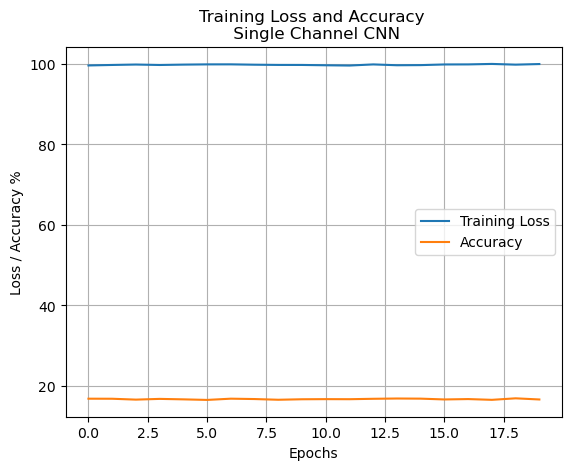

In [8]:
# visualize training loss and acc
def min_max_normalize(arr):
    return (arr - 0) / (np.max(arr) - 0)

norm1 = min_max_normalize(np.array(epoch_losses))* 100
norm2 = np.array(training_accuracies)  

plt.plot(norm1, label="Training Loss")
plt.plot(norm2, label="Accuracy")
plt.grid(True)
plt.title("Training Loss and Accuracy \n Single Channel CNN")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy %")
plt.legend()
plt.show()

In [18]:
# def is_SNN(model):
#     for name, module in model.named_modules():
#         if isinstance(module, snn.Leaky):
#             return True
#     return False

# model_type = 'SCNN' if is_SNN(model) else "CNN"
model_type = "CNN"
all_predictions = []
all_confidences = []
all_true_labels = []
librosa_bpm_estimates = []  # List to store Librosa's BPM estimates

# Set model to evaluation mode
model.eval()

# No gradient is needed during evaluation/inference
        # outputs, _ = model(data)
# No gradient is needed during evaluation/inference
with torch.no_grad():
    for data, target, librosa_bpm in val_loader:
        outputs = model(data)
        
        # Convert outputs to probabilities and extract predicted class & confidence
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidences, predicted_classes = torch.max(probabilities, dim=1) 
        predicted_classes_adjusted = predicted_classes + ground_truth_min
        all_predictions.extend(predicted_classes_adjusted.cpu().numpy())
        all_confidences.extend(confidences.cpu().numpy())
        all_true_labels.extend(target.cpu().numpy())
        librosa_bpm_estimates.extend(librosa_bpm.cpu().numpy())



# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_confidences = np.array(all_confidences)
librosa_bpm_estimates = np.array(librosa_bpm_estimates)

beepy.beep(sound=1)  # 1 for 'coin'

In [50]:
def visualize_based_on_threshold(threshold=0.5, tolerance=1.0):
    # Clear previous plots
    clear_output(wait=True)
    
    # Filter based on confidence threshold
    
    high_confidence_indices = np.where(all_confidences > threshold)
    filtered_predictions = all_predictions[high_confidence_indices]
    filtered_true_labels = all_true_labels[high_confidence_indices]
    filtered_accuracy = np.mean(np.abs(filtered_true_labels - filtered_predictions) <= tolerance) * 100
    correct_predictions = np.abs(all_true_labels - all_predictions) <= tolerance
    correct_predictions_lib = np.abs(all_true_labels - librosa_bpm_estimates) <= tolerance
    accuracy = np.mean(correct_predictions) * 100  # This gives the percentage of predictions within the defined range.
    accuracy_lib = np.mean(correct_predictions_lib) * 100  # This gives the percentage of predictions within the defined range.
    std_deviation_model = np.std(filtered_true_labels - filtered_predictions)
    std_deviation_librosa = np.std(all_true_labels - librosa_bpm_estimates)
        # Adding the ground truth line
    min_val = min(np.min(all_true_labels), np.min(all_predictions))
    max_val = max(np.max(all_true_labels), np.max(all_predictions))
    

    print(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {accuracy:.2f}%, Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}%")
    print(f"cnt  {len(filtered_predictions)}/{len(all_true_labels)}")
    # Update your scatter plot or any other visualizations using high_confidence_indices
    plt.figure(figsize=(8, 8))
    plt.scatter(all_true_labels[high_confidence_indices], all_predictions[high_confidence_indices], color='red', alpha=0.3, label='Model Predictions')
    plt.scatter(all_true_labels, librosa_bpm_estimates, alpha=0.3, color='green', label='Librosa Estimates')  # Plotting Librosa's BPM estimates in green
    plt.axhline(y=0, color='k', linestyle='--')
    plt.plot([min_val, max_val], [min_val, max_val], color='blue', linestyle='--', label='Ground Truth')

    plt.title(f"Model ({model_type}) accuracy within ±{tolerance} BPM: {filtered_accuracy:.2f}% (std: {std_deviation_model:.2f})\n" 
              f"Librosa accuracy within ±{tolerance} BPM: {accuracy_lib:.2f}% (std: {std_deviation_librosa:.2f})\n" 
              f"confidence threshold: {threshold}\n after {len(epoch_losses)} epochs")
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid(True)
    plt.legend()
    

    plt.show()
       
# Define and display slider
threshold_slider = widgets.FloatSlider(value=0.5, min=0, max=0.99, step=0.01, description='Confidence Threshold:')
tolerance_slider = widgets.IntSlider(value=1, min=1, max=30, step=1, description='Tolerance:')
widgets.interactive(visualize_based_on_threshold, threshold=threshold_slider, tolerance=tolerance_slider)

interactive(children=(FloatSlider(value=0.5, description='Confidence Threshold:', max=0.99, step=0.01), IntSli…

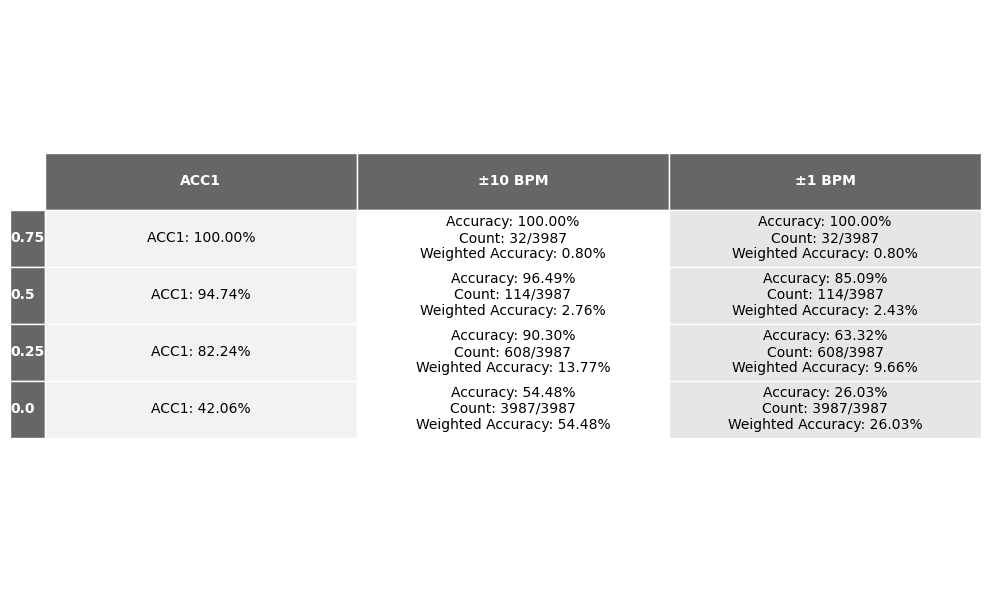

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_metrics(threshold):
    high_confidence_indices = np.where(all_confidences > threshold)
    filtered_predictions = all_predictions[high_confidence_indices]
    filtered_true_labels = all_true_labels[high_confidence_indices]
    
    acc1 = compute_ACC1(filtered_predictions, filtered_true_labels)
    metrics = {
        'acc1': acc1,
        'counts': []
    }
    
    for tolerance in [10, 1]:
        filtered_accuracy = np.mean(np.abs(filtered_true_labels - filtered_predictions) <= tolerance) * 100
        count = len(filtered_predictions)
        weighted_accuracy = (filtered_accuracy * count) / len(all_true_labels)
        metrics['counts'].append((filtered_accuracy, count, weighted_accuracy))
    
    return metrics

def compute_ACC1(predictions, true_labels, tolerance_ratio=0.04):
    """Compute ACC1 given predictions and true labels."""
    errors = np.abs(predictions - true_labels) / true_labels
    return np.mean(errors <= tolerance_ratio) * 100

def plot_table():
    confidences = [0.75, 0.5, 0.25, 0]
    metrics_data = []
    
    for threshold in confidences:
        metrics_data.append(compute_metrics(threshold))

    columns = ['ACC1', '±10 BPM', '±1 BPM']
    df = pd.DataFrame(index=confidences, columns=columns)

    for i, threshold in enumerate(confidences):
        df.at[threshold, 'ACC1'] = f"ACC1: {metrics_data[i]['acc1']:.2f}%"
        for j, tol in enumerate([10, 1]):
            df.at[threshold, f"±{tol} BPM"] = (f"Accuracy: {metrics_data[i]['counts'][j][0]:.2f}%"
                                              f"\nCount: {metrics_data[i]['counts'][j][1]}/{len(all_true_labels)}"
                                              f"\nWeighted Accuracy: {metrics_data[i]['counts'][j][2]:.2f}%")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    
    # Fixing the cellColours list
    cell_colors = []
    for _ in range(len(df)):
        cell_colors.append(["#f2f2f2", "#ffffff", "#e6e6e6"])

    # Using a gray background color for the table and alternating row colors for clarity
    the_table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, 
                         cellLoc='center', loc='center', 
                         cellColours=cell_colors,
                         colColours=["#666666"] * len(df.columns),
                         rowColours=["#666666"] * len(df))
    
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(10)
    the_table.scale(1.2, 1.2)
    for (i, j), cell in the_table.get_celld().items():
        if i == 0 or j == -1:
            cell.set_text_props(fontweight='bold', color='w')
        cell.set_edgecolor('w')
        
    # Adjust cell padding
    cellDict = the_table.get_celld()
    for key in cellDict:
        cellDict[key].set_height(0.1)  # Adjust as needed
        cellDict[key].PAD = 0.01  # Adjust as needed
        
    plt.tight_layout()
    plt.show()

plot_table()


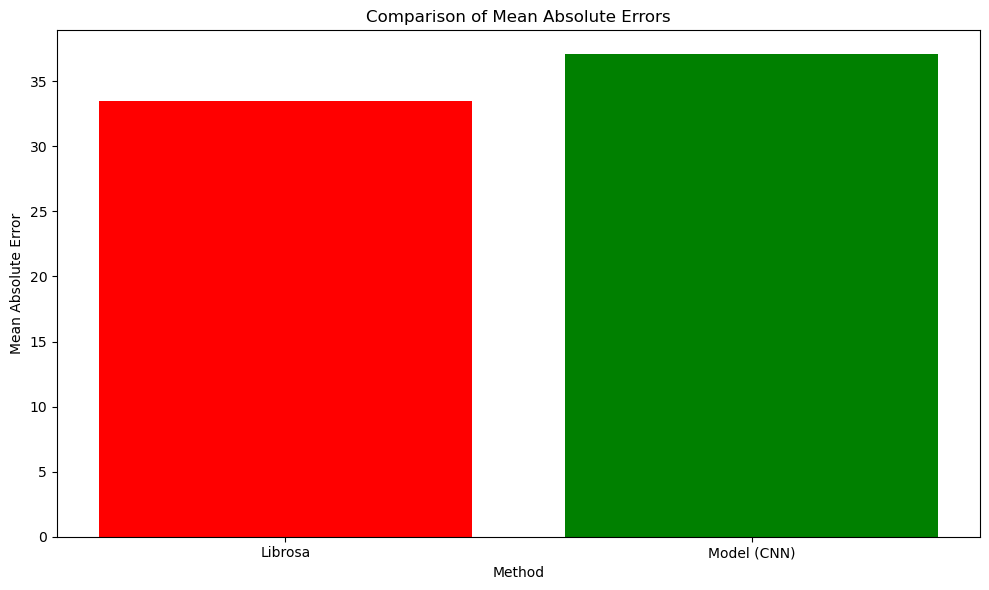

In [7]:

# Calculate Mean Absolute Errors
model_mae = np.mean(np.abs(all_true_labels - all_predictions))
librosa_mae = np.mean(np.abs(all_true_labels - librosa_bpm_estimates))

# Plot Mean Absolute Errors
model_label = f'Model ({model_type})'
labels = ['Librosa', model_label]
errors = [librosa_mae, model_mae]

plt.figure(figsize=(10, 6))
plt.bar(labels, errors, color=['red', 'green'])
plt.xlabel('Method')
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Errors')
plt.tight_layout()
plt.show()